In [1]:
# Init libraries
import warnings
import mne
import numpy as np
from aux.pre_process import get_one_subject_data_and_label
from sklearn.exceptions import ConvergenceWarning
from scipy import integrate
from scipy import stats
import antropy as ant
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn import metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

np.random.seed(23)
mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning )
warnings.filterwarnings(action = "ignore", category = FutureWarning )
warnings.filterwarnings(action = "ignore", category = ConvergenceWarning )

In [2]:
# Define all the features


def mean(x):
    return np.mean(x, axis=-1)

def std(x):
    return np.std(x, axis=-1)

def ptp(x):
    return np.ptp(x, axis=-1)

def var(x):
    return np.var(x, axis=-1)

def minim(x):
    return np.min(x, axis=-1)

def maxim(x):
    return np.max(x, axis=-1)

def argminim(x):
    return np. argmin(x, axis=-1)

def argmaxim(x):
    return np.argmax(x,axis=-1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1))

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def skewness(x):
    return stats.skew(x, axis=-1)

def kurtosis(x):
    return stats.kurtosis(x, axis=-1)

def f_minplusmax(x):
    return np.max(x, axis=-1) + np.min(x, axis=-1)

def f_maxminusmin(x):
    return np.max(x, axis=-1) - np.min(x, axis=-1)

def f_spec_entropy(x):
    return ant.spectral_entropy(x, fs, method="welch", normalize=True, axis=-1)

def f_integral(x):
    return integrate.simps(x, axis=-1)

def f_petrosian(x):
    return ant.petrosian_fd(x, axis=-1)

def f_katz(x):
    return ant.katz_fd(x, axis=-1)

def concatenate_features(x):
    # Uncomment the desired line to add the feature
    return np.concatenate((
        mean(x),
        std(x),
        ptp(x),
        var(x),
        minim(x),
        maxim(x),
        argminim(x),
        argmaxim(x),
        rms(x),
        abs_diff_signal(x),
        skewness(x),
        kurtosis(x),
        # f_minplusmax(x),
        # f_maxminusmin(x),
        # f_spec_entropy(x),
        # f_integral(x),
        # f_katz(x),
        # f_petrosian(x),
    ), axis=-1)

In [3]:
def run_cross_validation(classifier, k_fold, x_tr, y_tr):
    # Changed to use StratifiedKFold
    #k_fold = model_selection.StratifiedKFold(n_splits=5)
    results = model_selection.cross_val_score(classifier, x_tr, y_tr, cv=k_fold, scoring='accuracy')
    return results.mean()

In [4]:
# Project defaults
# The root dir
root_dir = "./ds003626"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

In [5]:
# Load dataset


subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
random_state = 42
splits = [0.10, 0.20, 0.30]

for subject in subjects:

    # The root dir
    root_dir = "./ds003626"

    # Sampling rate
    fs = 256

    # Select the useful par of each trial. Time in seconds
    t_start = 1.5
    t_end = 3.5

    print(f"Doing subject: {subject}")
    condition = "Inner"
    data, labels = get_one_subject_data_and_label(root_dir, subject, condition, t_start = t_start, t_end = t_end, fs = fs)

    #convert from list to array
    data_array=np.vstack(data)
    label_array=np.hstack(labels)

    # Make features
    features=[]
    for d in data_array:
     features.append(concatenate_features(d))
    features_array=np.array(features)

    # Run the experiment

    # Prepare the data
    X = features_array
    y = label_array
    #X = MinMaxScaler().fit_transform(X)
    X = StandardScaler().fit_transform(X)

    # Feature Selection - There are other parameters we could set for Feature Selection
    print("Old shape: ", X.shape)

    # Select one fs here
    fs = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
    # fs = SVC(kernel="linear").fit(X, y)
    # fs = ExtraTreesClassifier(n_estimators=50).fit(X, y)

    model = SelectFromModel(fs, prefit=True)
    X = model.transform(X)

    # or use this one
    # X = SelectKBest(chi2, k=100).fit_transform(X, y)

    print("New shape: ", X.shape)

    # Run cross validation with best hyperparameters found from all subjects

    outer_cv = StratifiedKFold(n_splits=5)

    classifiers = [
        ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=7, criterion='entropy')],
        ["Neural Network", MLPClassifier(random_state=random_state, alpha=1e-06, hidden_layer_sizes=11, max_iter=2000, solver='lbfgs')],
        ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
        ["SVC", SVC(random_state=random_state, max_iter=10000, C=10, kernel='linear')],
    ]

    for test_size in splits:
        print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
        print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

        # Stratify guarantees that the same proportion of the classes will be available in train and test
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

        for cls in classifiers:
            cls[1].fit(x_train, y_train)
            y_pred = cls[1].predict(x_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train)
            print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))
    print('******************************************************************')
    print('******************************************************************')
    print('******************************************************************')



Doing subject: 1
Old shape:  (200, 1536)
New shape:  (200, 659)

Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.2                  0.27222222222222225
Neural Network                           0.3                  0.33333333333333337
Linear SVC                               0.35                 0.3388888888888889
SVC                                      0.45                 0.3555555555555555

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.125                0.25625        
Neural Network                           0.3                  0.2875         
Linear SVC                               0.325                0.2625         
SVC                                      0.425                0.275          

Split: Train:70.0% Test:30.0%
Classifier                               Accura

[0.25, 0.2638888888888889, 0.25]


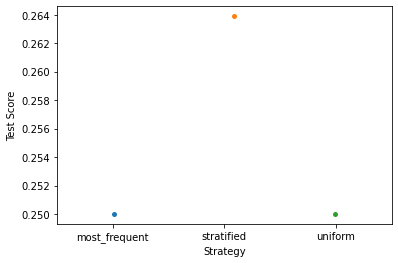

In [6]:
# Implementing Dummy Classifier to have a baseline for our models

from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt

strategies = ['most_frequent', 'stratified', 'uniform']

test_scores = []
for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = random_state)
    dclf.fit(x_train, y_train)
    score = dclf.score(x_test, y_test)
    test_scores.append(score)

print(test_scores)
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()

In [7]:
#Run until here for now, the rest of the code bellow hasn't been run

In [8]:
from matplotlib import pyplot as plt
def plot_result(history):
    rcParams['figure.figsize'] = (18, 8)
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False

    plt.plot(
    np.arange(1, 101),
        history.history['loss'], label='Loss'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['accuracy'], label='Accuracy'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['precision'], label='Precision'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['recall'], label='Recall'
    )
    plt.title('Evaluation metrics', size=20)
    plt.xlabel('Epoch', size=14)
    plt.legend()

2022-07-08 09:28:47.628447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-08 09:28:56.415991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-08 09:28:56.481437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-08 09:28:56.700854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 09:28:56.701487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2022-07-08 09:28:56.701831: I tensorflow/stream_executor/platform/def


Split: Train:90.0% Test:10.0%


2022-07-08 09:34:01.986345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-08 09:34:02.056897: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3692895000 Hz


Epoch 1/100


2022-07-08 09:34:02.942981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


7/7 [==============================] - 69s 2ms/step - loss: -953.5676 - accuracy: 0.2591 - precision: 0.8116 - recall: 0.7191
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: -106098.3281 - accuracy: 0.2159 - precision: 0.7469 - recall: 1.0000
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: -1313672.0469 - accuracy: 0.2676 - precision: 0.7601 - recall: 1.0000
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: -7325321.6875 - accuracy: 0.2526 - precision: 0.7510 - recall: 1.0000
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: -30102331.5000 - accuracy: 0.2349 - precision: 0.7389 - recall: 1.0000
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: -73237909.7500 - accuracy: 0.2577 - precision: 0.7217 - recall: 1.0000
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: -203070954.0000 - accuracy: 0.2431 - precision: 0.7271 - recall: 1.0000
Epoch 8/100
7/7 [========

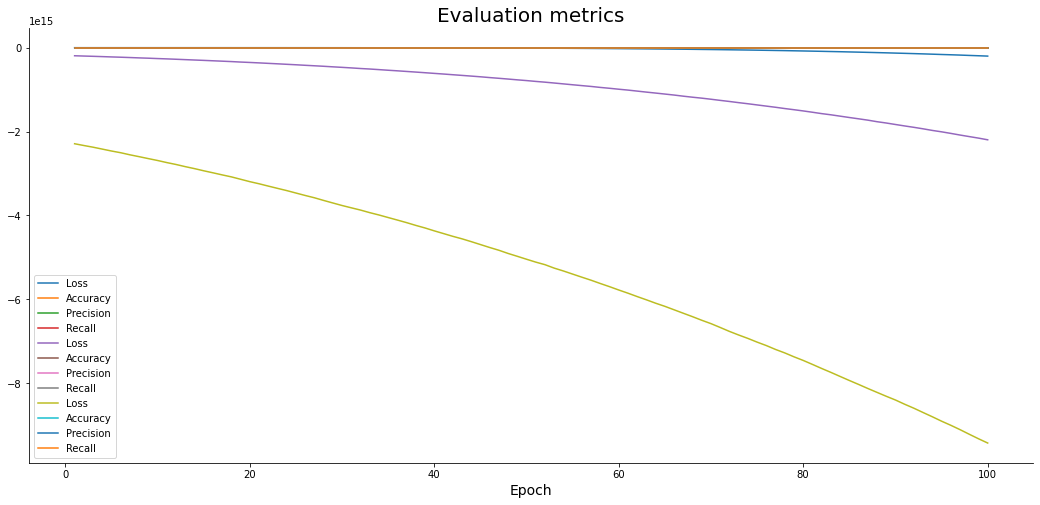

In [9]:
import tensorflow as tf
from matplotlib import rcParams
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    history = model.fit(x_train, y_train, epochs=100)
    plot_result(history)

In [10]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from others.eeg import EEGNet

def run_eeg():
    model = EEGNet(nb_classes = 4, Chans = 128, Samples = 512)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    Xx = data_array
    Yy = label_array

    x_train, x_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.20, stratify=y)

    # convert labels to one-hot encodings.
    Y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    X_train = x_train.reshape(x_train.shape[0], 128, 512)
    X_test = x_test.reshape(x_test.shape[0], 128, 512)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print('X_test shape:', X_test.shape)
    print(X_test.shape[0], 'test samples')

    print('Y_train shape:', Y_train.shape)
    print(Y_train.shape[0], 'train samples')
    print('Y_test shape:', Y_test.shape)
    print(Y_test.shape[0], 'test samples')

    # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other
    # model configurations may do better, but this is a good starting point)
    model = EEGNet(nb_classes = 4, Chans = 128, Samples = 512)

    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    # count number of parameters in the model
    numParams    = model.count_params()

    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, verbose = 2)

run_eeg()

X_train shape: (192, 128, 512)
192 train samples
X_test shape: (48, 128, 512)
48 test samples
Y_train shape: (192, 4)
192 train samples
Y_test shape: (48, 4)
48 test samples
Epoch 1/300


2022-07-08 09:35:17.163348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-08 09:45:46.594841: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-08 09:45:46.629910: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


12/12 - 632s - loss: nan - accuracy: 0.2500
Epoch 2/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 3/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 4/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 5/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 6/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 7/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 8/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 9/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 10/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 11/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 12/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 13/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 14/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 15/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 16/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 17/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 18/300
12/12 - 0s - loss: nan - accuracy: 0.2500
Epoch 19/300
12/12 - 0s - los